In [ ]:
import sys
import os
import random
import torch
import numpy as np
import itertools
import pandas as pd
import csv
from tqdm import tqdm
from box import Box

# Ajustar path al proyecto
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)

from scripts.dataset_loader import load_dataset
from scripts.medical_scripts.medical_training import Training
from scripts.medical_scripts.medical_evaluation import ModelEvaluator
from scripts.MIL_utils import MIL_collate_fn

def run_experiment(config: Box):
    # Fijar semillas
    seed = config.seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Crear directorio de salida
    out_dir = f"./models/{config.dataset_name.split('-')[0]}/{config.pooling_type}/seed{seed}"
    os.makedirs(out_dir, exist_ok=True)

    # Cargar datos
    train_ds, val_ds = load_dataset(config=config, mode="train_val")
    test_ds          = load_dataset(config=config, mode="test")
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=config.batch_size,
                                               shuffle=True,  collate_fn=MIL_collate_fn)
    val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=config.batch_size,
                                               shuffle=False, collate_fn=MIL_collate_fn)
    test_loader  = torch.utils.data.DataLoader(test_ds,  batch_size=config.batch_size,
                                               shuffle=False, collate_fn=MIL_collate_fn)

    # Entrenamiento
    trainer = Training(
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=config.num_epochs,
        learning_rate=config.learning_rate,
        output_model_dir=out_dir,
        pooling_type=config.pooling_type,
        input_feature_dim=config.input_feature_dim,
        feature_dim=config.feature_dim,
        wandb=None
    )
    trainer.train()

    # Número de épocas entrenadas
    # Ajusta `trainer.current_epoch` por el atributo que uses internamente
    trained_epochs = getattr(trainer, 'current_epoch', config.num_epochs)

    # Guardar modelo
    model_path = os.path.join(out_dir, "model.pth")
    torch.save(trainer.model.state_dict(), model_path)

    # Evaluación en train
    evaluator_train = ModelEvaluator(
        model_path=model_path,
        test_loader=train_loader,
        batch_size=config.batch_size,
        input_feature_dim=config.input_feature_dim,
        feature_dim=config.feature_dim,
        pooling_type=config.pooling_type,
        wandb=None
    )
    train_metrics, _ = evaluator_train.evaluate()
    print(f"Train AUC: {train_metrics.get('auc')}")

    # Evaluación en test
    evaluator_test = ModelEvaluator(
        model_path=model_path,
        test_loader=test_loader,
        batch_size=config.batch_size,
        input_feature_dim=config.input_feature_dim,
        feature_dim=config.feature_dim,
        pooling_type=config.pooling_type,
        wandb=None
    )
    test_metrics, _ = evaluator_test.evaluate()
    print(f"Test AUC: {test_metrics.get('auc')}")

    # Devolver métricas + épocas
    return {
        "trained_epochs": trained_epochs,
        **{f"train_{k}": v for k, v in train_metrics.items()},
        **{f"test_{k}":  v for k, v in test_metrics.items()}
    }


def run_all_experiments():
    csv_file = "RSNA_experiment_runs.csv"
    header = [
        "dataset", "pooling", "learning_rate", "feature_dim", "seed",
        "trained_epochs",
        # métricas de train
        "train_loss", "train_accuracy", "train_f1_score", "train_auc", "train_precision", "train_recall",
        # métricas de test
        "test_loss",  "test_accuracy",  "test_f1_score",  "test_auc",  "test_precision",  "test_recall"
    ]

    # Cargar progreso previo
    if os.path.exists(csv_file):
        df_done = pd.read_csv(csv_file)
        print("Últimos experimentos:")
        display(df_done.tail())
        done_set = set(zip(
            df_done.dataset, df_done.pooling,
            df_done.learning_rate, df_done.feature_dim, df_done.seed
        ))
    else:
        with open(csv_file, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(header)
        done_set = set()
        print("No se encontró CSV previo. Empezando desde cero.")

    # Rejilla de hiperparámetros
    datasets       = ["rsna-features_resnet18"]
    pooling_types  = ["attention", "mean", "max"]
    learning_rates = [1e-3, 1e-4]
    feature_dims   = [64, 128]
    seeds          = list(range(5))

    for dataset, pooling, lr, feat_dim in tqdm(
        itertools.product(datasets, pooling_types, learning_rates, feature_dims),
        desc="Grid search RSNA"
    ):
        for seed in seeds:
            key = (dataset, pooling, lr, feat_dim, seed)
            if key in done_set:
                continue

            # Parámetros dinámicos
            input_feat_dim = 512 if "rsna" in dataset else 1024
            num_epochs     = 50  if "rsna" in dataset else 15

            config = Box({
                "dataset_name":      dataset,
                "input_feature_dim": input_feat_dim,
                "feature_dim":       feat_dim,
                "pooling_type":      pooling,
                "num_epochs":        num_epochs,
                "learning_rate":     lr,
                "batch_size":        1,
                "val_prop":          0.2,
                "seed":              seed,
                "use_inst_distances": False,
                "adj_mat_mode":      "relative"
            })

            print(f"\n=== Ejecutando: {dataset}, {pooling}, lr={lr}, feat_dim={feat_dim}, seed={seed} ===")
            metrics = run_experiment(config)

            # Preparar fila
            row = [
                dataset, pooling, lr, feat_dim, seed,
                metrics.get("trained_epochs", ""),
                metrics.get("train_loss", ""),
                metrics.get("train_accuracy", ""),
                metrics.get("train_f1_score", ""),
                metrics.get("train_auc", ""),
                metrics.get("train_precision", ""),
                metrics.get("train_recall", ""),
                metrics.get("test_loss", ""),
                metrics.get("test_accuracy", ""),
                metrics.get("test_f1_score", ""),
                metrics.get("test_auc", ""),
                metrics.get("test_precision", ""),
                metrics.get("test_recall", ""),
            ]

            # Guardar inmediatamente
            with open(csv_file, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow(row)

            done_set.add(key)

    print("\nTodos los experimentos quedan registrados en", csv_file)

if __name__ == "__main__":
    run_all_experiments()


Últimos experimentos:


,dataset,pooling,learning_rate,feature_dim,seed,trained_epochs,train_loss,train_accuracy,train_f1_score,train_auc,train_precision,train_recall,test_loss,test_accuracy,test_f1_score,test_auc,test_precision,test_recall
55,rsna-features_resnet18,max,0.0001,128,0,50,NaN,0.93500,0.920973,0.973070,0.920973,0.920973,NaN,0.866667,0.859155,0.899573,0.871429,0.847222
56,rsna-features_resnet18,max,0.0001,128,1,50,NaN,0.97625,0.971429,0.991256,0.961310,0.981763,NaN,0.866667,0.850746,0.921652,0.919355,0.791667
57,rsna-features_resnet18,max,0.0001,128,2,50,NaN,0.95500,0.945122,0.983202,0.948012,0.942249,NaN,0.840000,0.820896,0.903312,0.887097,0.763889
58,rsna-features_resnet18,max,0.0001,128,3,50,NaN,0.97625,0.971429,0.996631,0.961310,0.981763,NaN,0.846667,0.841379,0.904202,0.835616,0.847222
59,rsna-features_resnet18,max,0.0001,128,4,50,NaN,0.96500,0.958457,0.994657,0.936232,0.981763,NaN,0.833333,0.829932,0.913640,0.813333,0.847222


Grid search RSNA: 12it [00:00, 160803.99it/s]


Todos los experimentos quedan registrados en RSNA_experiment_runs.csv


In [4]:
import pandas as pd
import numpy as np

# Cargar el CSV
df = pd.read_csv('RSNA_experiment_runs.csv')

# Definir las métricas para calcular estadísticas
metrics_to_analyze = [
    'train_accuracy', 'train_f1_score', 'train_auc', 'train_precision', 'train_recall',
    'test_accuracy', 'test_f1_score', 'test_auc', 'test_precision', 'test_recall'
]

# Agrupar por hiperparámetros (excluyendo seed)
groupby_cols = ['dataset', 'pooling', 'learning_rate', 'feature_dim']

# Calcular estadísticas agrupadas
results_summary = []

for group_name, group_data in df.groupby(groupby_cols):
    dataset, pooling, lr, feature_dim = group_name
    
    # Crear diccionario base para este grupo
    row = {
        'dataset': dataset,
        'pooling': pooling,
        'learning_rate': lr,
        'feature_dim': feature_dim,
        'n_seeds': len(group_data)
    }
    
    # Calcular medias y desviaciones para cada métrica
    for metric in metrics_to_analyze:
        if metric in group_data.columns:
            values = group_data[metric].dropna()
            if len(values) > 0:
                row[f'{metric}_mean'] = values.mean()
                row[f'{metric}_std'] = values.std() if len(values) > 1 else 0.0
    
    results_summary.append(row)

# Convertir a DataFrame
df_clean = pd.DataFrame(results_summary)

# Guardar CSV limpio
df_clean.to_csv('RSNA_clean.csv', index=False, float_format='%.6f')

print(f"CSV limpio guardado en 'RSNA_clean.csv' con {len(df_clean)} configuraciones")

CSV limpio guardado en 'RSNA_clean.csv' con 12 configuraciones


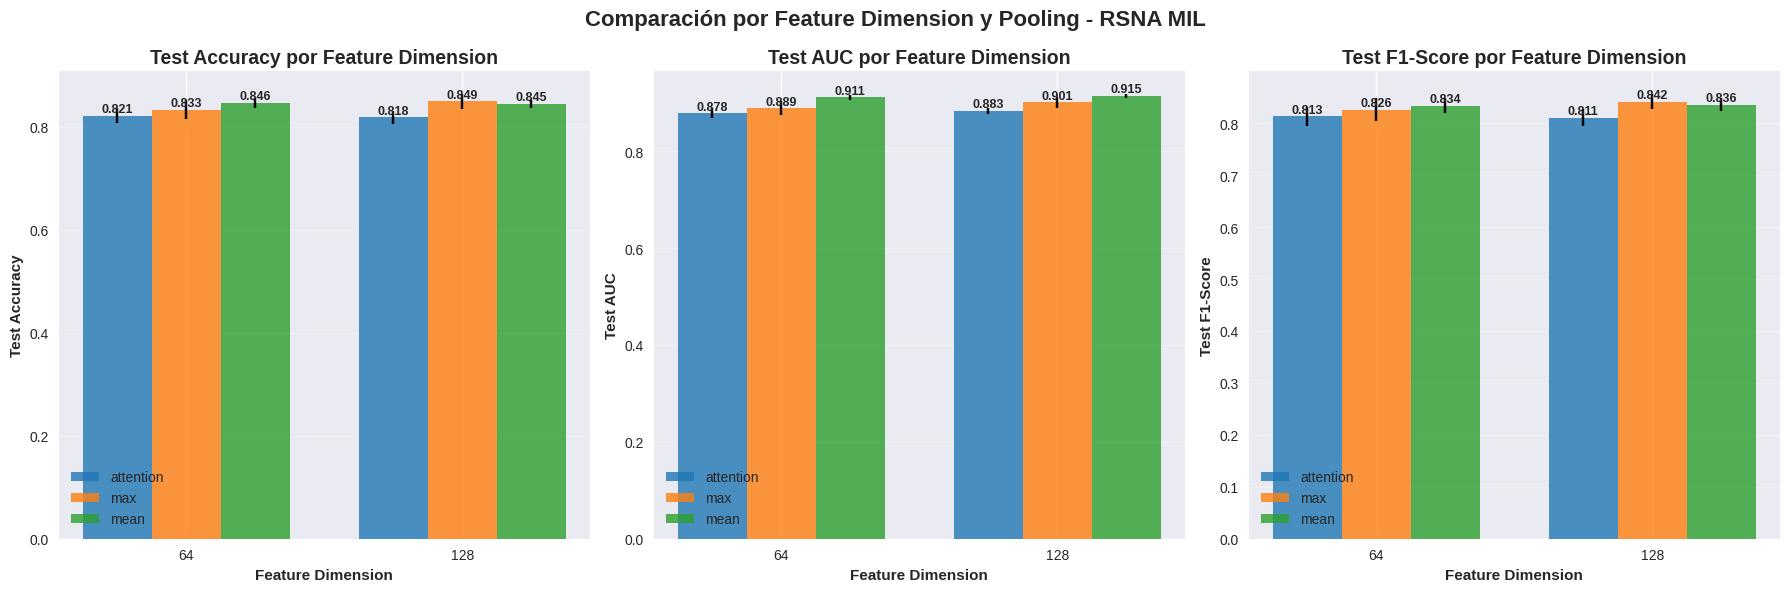

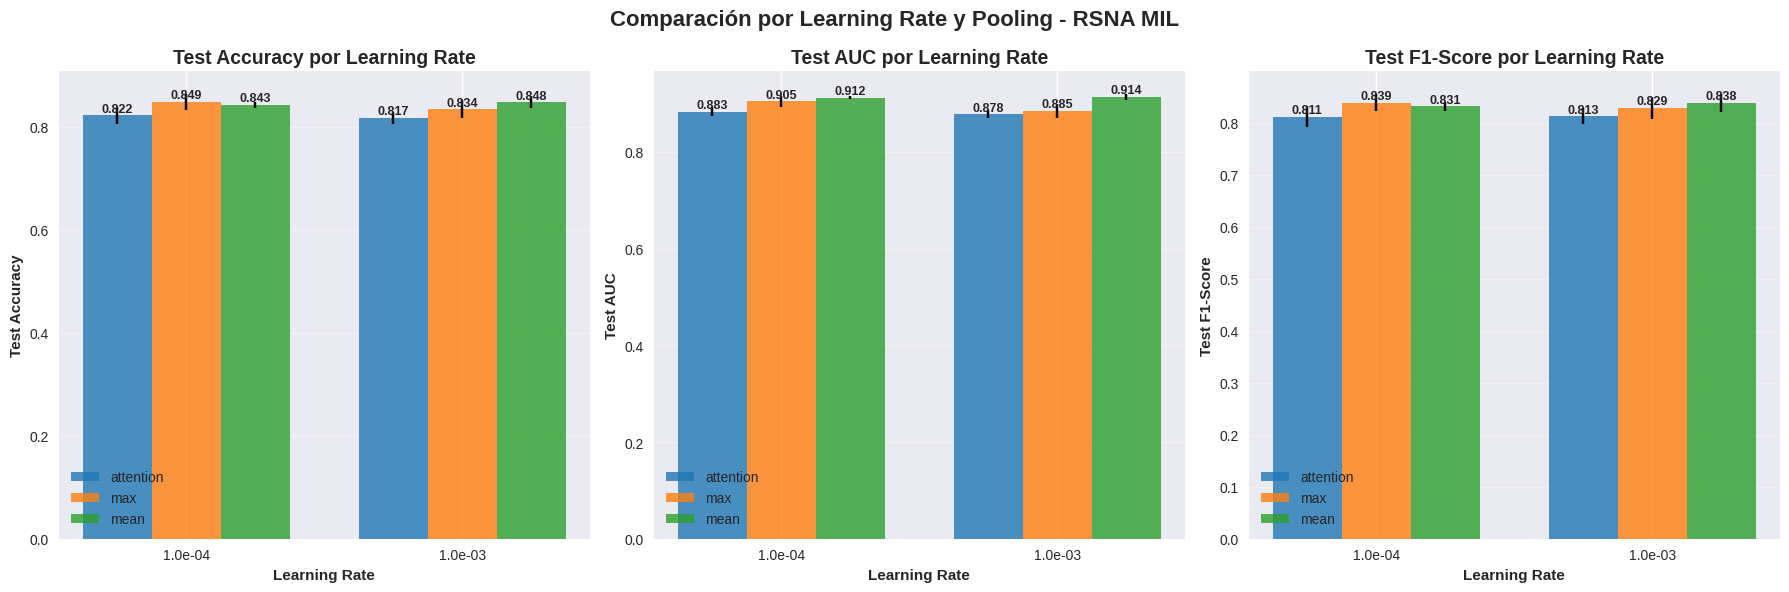

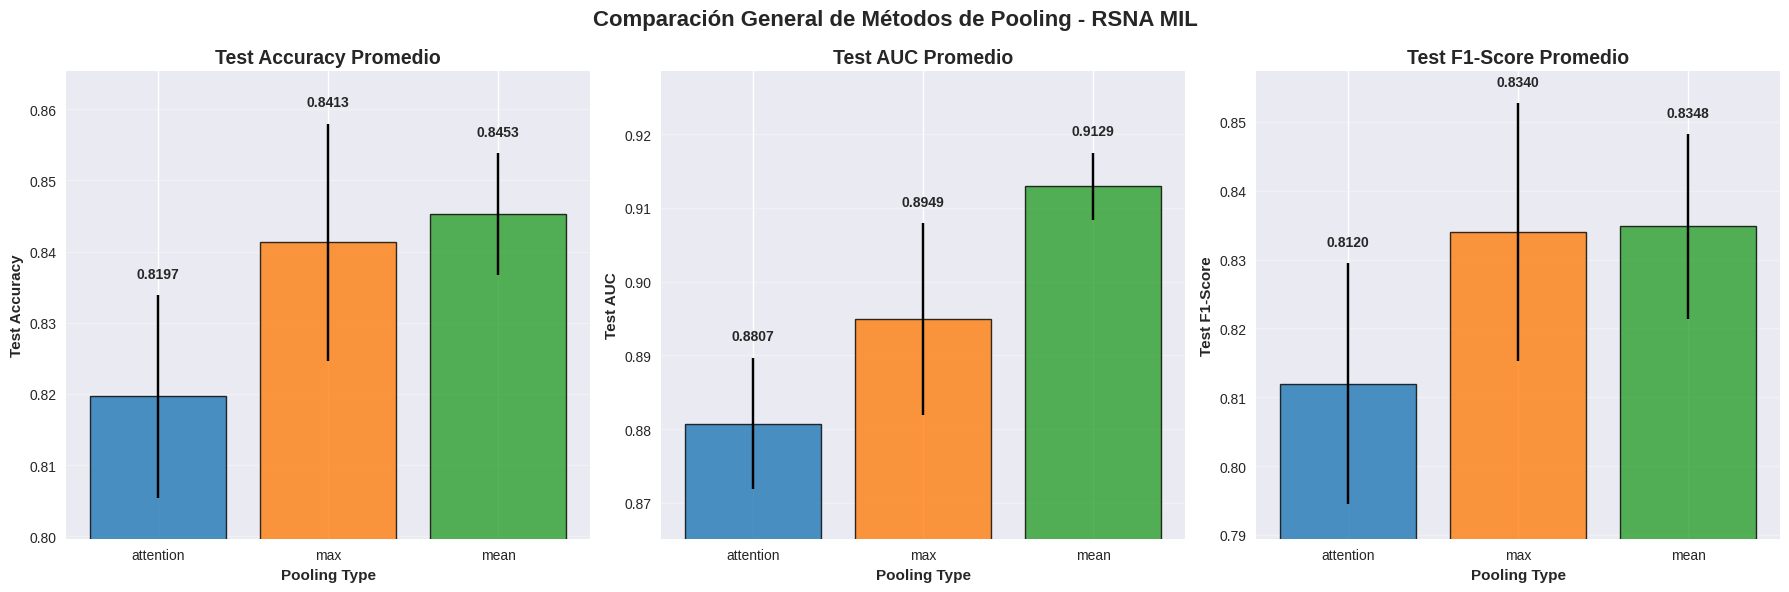


=== RESUMEN ESTADÍSTICO POR POOLING ===
          test_accuracy_mean         test_auc_mean         test_f1_score_mean  \
                        mean     std          mean     std               mean   
pooling                                                                         
attention             0.8197  0.0067        0.8807  0.0059             0.8120   
max                   0.8413  0.0143        0.8949  0.0139             0.8340   
mean                  0.8453  0.0033        0.9129  0.0025             0.8348   

                   
              std  
pooling            
attention  0.0072  
max        0.0129  
mean       0.0045  

=== RESUMEN POR FEATURE DIMENSION Y POOLING ===

--- Feature Dimension: 64 ---
           test_accuracy_mean  test_auc_mean  test_f1_score_mean
pooling                                                         
attention              0.8213         0.8785              0.8131
max                    0.8333         0.8888              0.8261
mean        

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Cargar el CSV limpio
df = pd.read_csv('RSNA_clean.csv')

# Configurar estilo
plt.style.use('seaborn-v0_8')

# Métricas a visualizar (usando las medias calculadas)
metrics = ['test_accuracy_mean', 'test_auc_mean', 'test_f1_score_mean']
titles = ['Test Accuracy', 'Test AUC', 'Test F1-Score']
std_metrics = ['test_accuracy_std', 'test_auc_std', 'test_f1_score_std']

# =================== PRIMERA IMAGEN: Comparación por Feature Dimension ===================
fig1, axes1 = plt.subplots(1, 3, figsize=(18, 6))
fig1.suptitle('Comparación por Feature Dimension y Pooling - RSNA MIL', fontsize=16, fontweight='bold')

for i, (metric, title, std_metric) in enumerate(zip(metrics, titles, std_metrics)):
    ax = axes1[i]
    
    # Obtener feature dimensions únicos y ordenados
    feature_dims = sorted(df['feature_dim'].unique())
    pooling_types = sorted(df['pooling'].unique())
    
    # Configurar posiciones para barras agrupadas
    x = np.arange(len(feature_dims))
    width = 0.25
    
    # Crear barras para cada pooling type
    for j, pool_type in enumerate(pooling_types):
        means_by_dim = []
        stds_by_dim = []
        
        for feature_dim in feature_dims:
            subset = df[(df['pooling'] == pool_type) & (df['feature_dim'] == feature_dim)]
            if len(subset) > 0:
                means_by_dim.append(subset[metric].mean())
                stds_by_dim.append(subset[std_metric].mean())
            else:
                means_by_dim.append(0)
                stds_by_dim.append(0)
        
        bars = ax.bar(x + j*width, means_by_dim, width, 
                     yerr=stds_by_dim, capsize=3,
                     label=pool_type, alpha=0.8,
                     color=['#1f77b4', '#ff7f0e', '#2ca02c'][j])
        
        # Añadir valores en las barras
        for k, (bar, mean) in enumerate(zip(bars, means_by_dim)):
            if mean > 0:  # Solo mostrar si hay datos
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                       f'{mean:.3f}', ha='center', va='bottom', 
                       fontsize=9, fontweight='bold')
    
    ax.set_title(f'{title} por Feature Dimension', fontweight='bold', fontsize=14)
    ax.set_xlabel('Feature Dimension', fontweight='bold')
    ax.set_ylabel(title, fontweight='bold')
    ax.set_xticks(x + width)
    ax.set_xticklabels(feature_dims)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('rsna_pooling_by_featuredim.png', dpi=300, bbox_inches='tight')
plt.show()

# =================== SEGUNDA IMAGEN: Comparación por Learning Rate ===================
fig2, axes2 = plt.subplots(1, 3, figsize=(18, 6))
fig2.suptitle('Comparación por Learning Rate y Pooling - RSNA MIL', fontsize=16, fontweight='bold')

for i, (metric, title, std_metric) in enumerate(zip(metrics, titles, std_metrics)):
    ax = axes2[i]
    
    # Obtener learning rates únicos y ordenados
    learning_rates = sorted(df['learning_rate'].unique())
    pooling_types = sorted(df['pooling'].unique())
    
    # Configurar posiciones para barras agrupadas
    x = np.arange(len(learning_rates))
    width = 0.25
    
    # Crear barras para cada pooling type
    for j, pool_type in enumerate(pooling_types):
        means_by_lr = []
        stds_by_lr = []
        
        for lr in learning_rates:
            subset = df[(df['pooling'] == pool_type) & (df['learning_rate'] == lr)]
            if len(subset) > 0:
                means_by_lr.append(subset[metric].mean())
                stds_by_lr.append(subset[std_metric].mean())
            else:
                means_by_lr.append(0)
                stds_by_lr.append(0)
        
        bars = ax.bar(x + j*width, means_by_lr, width, 
                     yerr=stds_by_lr, capsize=3,
                     label=pool_type, alpha=0.8,
                     color=['#1f77b4', '#ff7f0e', '#2ca02c'][j])
        
        # Añadir valores en las barras
        for k, (bar, mean) in enumerate(zip(bars, means_by_lr)):
            if mean > 0:  # Solo mostrar si hay datos
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                       f'{mean:.3f}', ha='center', va='bottom', 
                       fontsize=9, fontweight='bold')
    
    ax.set_title(f'{title} por Learning Rate', fontweight='bold', fontsize=14)
    ax.set_xlabel('Learning Rate', fontweight='bold')
    ax.set_ylabel(title, fontweight='bold')
    ax.set_xticks(x + width)
    ax.set_xticklabels([f'{lr:.1e}' for lr in learning_rates])  # Notación científica
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('rsna_pooling_by_lr.png', dpi=300, bbox_inches='tight')
plt.show()

# =================== TERCERA IMAGEN: Comparación General ===================
fig3, axes3 = plt.subplots(1, 3, figsize=(18, 6))
fig3.suptitle('Comparación General de Métodos de Pooling - RSNA MIL', fontsize=16, fontweight='bold')

for i, (metric, title, std_metric) in enumerate(zip(metrics, titles, std_metrics)):
    ax = axes3[i]
    
    # Barplot con error bars
    pooling_types = sorted(df['pooling'].unique())
    x_pos = np.arange(len(pooling_types))
    
    means = []
    stds = []
    
    for pool_type in pooling_types:
        subset = df[df['pooling'] == pool_type]
        means.append(subset[metric].mean())
        stds.append(subset[std_metric].mean())
    
    bars = ax.bar(x_pos, means, yerr=stds, capsize=5, 
                  color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8,
                  edgecolor='black', linewidth=1)
    
    ax.set_title(f'{title} Promedio', fontweight='bold', fontsize=14)
    ax.set_xlabel('Pooling Type', fontweight='bold')
    ax.set_ylabel(title, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(pooling_types)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Configurar límites del eje Y para resaltar diferencias
    y_min = min(means) - max(stds) * 1.2
    y_max = max(means) + max(stds) * 1.2
    ax.set_ylim(y_min, y_max)
    
    # Añadir valores en las barras
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.002,
                f'{mean:.4f}', ha='center', va='bottom', 
                fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('rsna_pooling_general.png', dpi=300, bbox_inches='tight')
plt.show()

# =================== RESÚMENES ESTADÍSTICOS ===================
print("\n=== RESUMEN ESTADÍSTICO POR POOLING ===")
summary = df.groupby('pooling')[['test_accuracy_mean', 'test_auc_mean', 'test_f1_score_mean']].agg(['mean', 'std'])
print(summary.round(4))

print("\n=== RESUMEN POR FEATURE DIMENSION Y POOLING ===")
for feature_dim in sorted(df['feature_dim'].unique()):
    print(f"\n--- Feature Dimension: {feature_dim} ---")
    subset = df[df['feature_dim'] == feature_dim]
    dim_summary = subset.groupby('pooling')[['test_accuracy_mean', 'test_auc_mean', 'test_f1_score_mean']].mean()
    print(dim_summary.round(4))

print("\n=== RESUMEN POR LEARNING RATE Y POOLING ===")
for lr in sorted(df['learning_rate'].unique()):
    print(f"\n--- Learning Rate: {lr:.1e} ---")
    subset = df[df['learning_rate'] == lr]
    lr_summary = subset.groupby('pooling')[['test_accuracy_mean', 'test_auc_mean', 'test_f1_score_mean']].mean()
    print(lr_summary.round(4))

# Mejor configuración por métrica
print("\n=== MEJORES CONFIGURACIONES ===")
for metric in metrics:
    best_idx = df[metric].idxmax()
    best_config = df.loc[best_idx]
    print(f"\nMejor {metric.replace('test_', '').replace('_mean', '').upper()}:")
    print(f"  Pooling: {best_config['pooling']}")
    print(f"  Feature Dimension: {best_config['feature_dim']}")
    print(f"  Learning Rate: {best_config['learning_rate']:.1e}")
    print(f"  Valor: {best_config[metric]:.4f}")

print(f"\n=== IMÁGENES GENERADAS ===")
print("1. rsna_pooling_by_featuredim.png - Comparación por feature dimension")
print("2. rsna_pooling_by_lr.png - Comparación por learning rate")
print("3. rsna_pooling_general.png - Comparación general promedio")